In [1]:
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#### Function to read audio from .wav files

In [3]:
def read_audio(x):
    y = librosa.load(x)[0]
    return librosa.util.fix_length(y, size=11025)

#### Function to convert each audiowave into mel-spectrogram images

In [4]:
def calc_mel_spectrogram(y, sr = 22050, n_fft = 2048, hop_length = 512, n_mels=128):
    spect = librosa.feature.melspectrogram(y=y, n_fft=n_fft, sr=sr, hop_length=hop_length, n_mels = n_mels)
    return librosa.power_to_db(spect, ref=np.max)
    

#### Function to assign labels to each audio file based on patient metadata (clinical information)

In [5]:
def find_label(participant):
    return clinical_data['tb_status'][clinical_data['participant']==participant].to_list()[0]

##### Reading metadata and clinical_information file from the directory and assigning labels to each audio file

In [6]:
clinical_data = pd.read_csv("/Users/sudac/Downloads/Clinical_Meta.csv")
metadata_solicited = pd.read_csv("/Users/sudac/Downloads/Solicited_Meta.csv")

In [8]:
label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
metadata_solicited['label'] = label
metadata_solicited['relative_path'] = '/Users/sudac/Downloads/solicited/' + metadata_solicited['filename']


/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_28553/2004086151.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())


In [9]:
print(metadata_solicited)

       participant                       filename  sound_prediction_score  \
0     CODA_TB_0001  1645088710003-recording-1.wav                0.990254   
1     CODA_TB_0001  1645088760390-recording-1.wav                0.990272   
2     CODA_TB_0001  1645088760830-recording-1.wav                0.990112   
3     CODA_TB_0001  1645088710843-recording-1.wav                0.990152   
4     CODA_TB_0001  1645088759950-recording-1.wav                0.990039   
...            ...                            ...                     ...   
9767  CODA_TB_1107  1658214018804-recording-1.wav                0.941761   
9768  CODA_TB_1107  1658213992939-recording-1.wav                0.904569   
9769  CODA_TB_1107  1658213992139-recording-1.wav                0.934713   
9770  CODA_TB_1107  1658213940569-recording-1.wav                0.912813   
9771  CODA_TB_1107  1658213974948-recording-1.wav                0.939352   

      label                                      relative_path  
0         

#### Splits a Pandas dataframe into three subsets (train, val, and test) following fractional ratios provided by the user

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='label',
                                         frac_train=0.70, frac_val=0.15, frac_test=0.15,
                                         random_state=1):
    if round(frac_train + frac_val + frac_test) != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    # Ensure stratify_colname is a string
    stratify_colname = str(stratify_colname)

    # Create a dictionary to map the random labels to their corresponding percentages
    split_dict = {'train': frac_train, 'val': frac_val, 'test': frac_test}

    # Randomly assign 'train', 'val', 'test' labels based on the split percentages
    def assign_split_label(participant_group):
        return np.random.choice(['train', 'val', 'test'], p=[split_dict['train'], split_dict['val'], split_dict['test']])

    # Assuming df_input is your DataFrame containing participant information
    df_input['split_label'] = df_input.groupby(stratify_colname)[stratify_colname].transform(assign_split_label)
    df_input = df_input.reset_index(drop=True)

    # Split the dataframe into train, val, and test based on the assigned labels
    df_train = df_input[df_input['split_label'] == 'train']
    df_val = df_input[df_input['split_label'] == 'val']
    df_test = df_input[df_input['split_label'] == 'test']

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

# Example usage
df_train, df_val, df_test = split_stratified_into_train_val_test(metadata_solicited, stratify_colname="participant", random_state=42)


In [11]:
num_unique_participants = len(metadata_solicited['participant'].unique())
print(f"Number of unique participants: {num_unique_participants}")


Number of unique participants: 1082


##### The metadata data file is split into 3 components in the ratio train:val:test = 6:2:2

In [12]:
# Print information for participant "CODA_TB_001"
participant_id_column = 'participant'  # Replace with the actual column name representing participant IDs

if 'CODA_TB_0002' in df_train[participant_id_column].values:
    print("Participant CODA_TB_001 is in the training set.")
if 'CODA_TB_0002' in df_val[participant_id_column].values:
    print("Participant CODA_TB_001 is in the validation set.")
if 'CODA_TB_0002' in df_test[participant_id_column].values:
    print("Participant CODA_TB_001 is in the test set.")



Participant CODA_TB_001 is in the test set.


##### Read all the files (train, test and val) and converting them into mel-spectrogram images

In [13]:
from tqdm import tqdm
# Assuming df_test['relative_path'] is a column containing file paths
file_paths_test = df_test['relative_path'].tolist()

# Process files sequentially
list_audio_test = []
for file_path in tqdm(file_paths_test, desc="Processing Files", unit="file"):
    list_audio_test.append(read_audio(file_path))


Processing Files:   0%|          | 0/1580 [00:00<?, ?file/s]

Processing Files: 100%|██████████| 1580/1580 [00:01<00:00, 859.15file/s] 


In [14]:
from tqdm import tqdm
# Assuming df_test['relative_path'] is a column containing file paths
file_paths_train = df_train['relative_path'].tolist()

# Process files sequentially
list_audio_train = []
for file_path in tqdm(file_paths_train, desc="Processing Files", unit="file"):
    list_audio_train.append(read_audio(file_path))


Processing Files: 100%|██████████| 6806/6806 [00:04<00:00, 1542.21file/s]


In [15]:
from tqdm import tqdm
# Assuming df_test['relative_path'] is a column containing file paths
file_paths_val = df_val['relative_path'].tolist()

# Process files sequentially
list_audio_val = []
for file_path in tqdm(file_paths_val, desc="Processing Files", unit="file"):
    list_audio_val.append(read_audio(file_path))

Processing Files: 100%|██████████| 1386/1386 [00:00<00:00, 1601.13file/s]


In [16]:
# import numpy as np
# from tqdm import tqdm

# # Define the function to calculate mel spectrogram with tqdm progress bar
# def calc_mel_spectrogram_with_progress(audio_path):
#     return calc_mel_spectrogram(audio_path)

# # Use tqdm for progress bar during mel spectrogram calculation
# mel_spectrogram_train = np.array(list(tqdm(map(calc_mel_spectrogram_with_progress, list_audio_train), total=len(list_audio_train), desc="Calculating Mel Spectrogram (Train)")))
# mel_spectrogram_val = np.array(list(tqdm(map(calc_mel_spectrogram_with_progress, list_audio_val), total=len(list_audio_val), desc="Calculating Mel Spectrogram (Validation)")))
# mel_spectrogram_test = np.array(list(tqdm(map(calc_mel_spectrogram_with_progress, list_audio_test), total=len(list_audio_test), desc="Calculating Mel Spectrogram (Test)")))

# # Save mel spectrograms to files
# np.save('mel_spectrogram_train.npy', mel_spectrogram_train)
# np.save('mel_spectrogram_val.npy', mel_spectrogram_val)
# np.save('mel_spectrogram_test.npy', mel_spectrogram_test)


Calculating Mel Spectrogram (Test): 100%|██████████| 1580/1580 [00:04<00:00, 351.16it/s]


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import librosa


from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [26]:
# load mel spectrograms from files
mel_spectrogram_train = np.load('mel_spectrogram_train.npy')
mel_spectrogram_val = np.load('mel_spectrogram_val.npy')
mel_spectrogram_test = np.load('mel_spectrogram_test.npy')

X_train = np.expand_dims(mel_spectrogram_train, -1)
X_val = np.expand_dims(mel_spectrogram_val, -1)
X_test = np.expand_dims(mel_spectrogram_test, -1)

In [27]:
# load df from file 
df_train = pd.read_csv('/Users/sudac/Downloads/solicited/train.csv')
df_val = pd.read_csv('/Users/sudac/Downloads/solicited/val.csv')
df_test = pd.read_csv('/Users/sudac/Downloads/solicited/test.csv')

y_train = df_train['label']
y_val = df_val['label']
y_test = df_test['label']

print(df_train['label'].value_counts())
print(df_val['label'].value_counts())
print(df_test['label'].value_counts())

label
0    4807
1    1999
Name: count, dtype: int64
label
0    983
1    403
Name: count, dtype: int64
label
0    1052
1     528
Name: count, dtype: int64


In [28]:
# librosa.display.waveshow(list_audio_train[0])

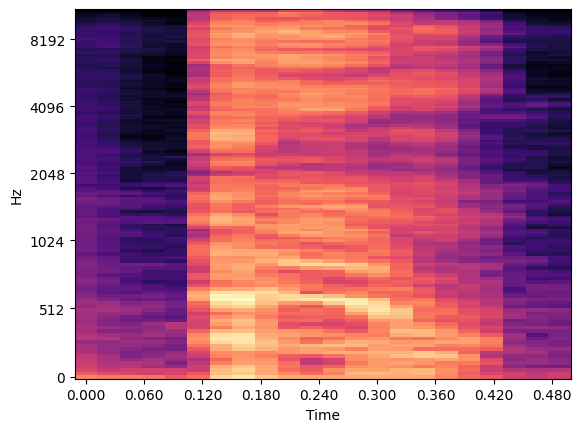

In [29]:
librosa.display.specshow(mel_spectrogram_train[1], y_axis='mel', x_axis='time', auto_aspect=True)
#plt.savefig()

#### Model development using tensorflow

In [30]:
input_shape = X_train.shape[1:]
print('Input shape:', input_shape)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(128, 128),

    layers.Conv2D(16, 3, activation='relu'),
    layers.AveragePooling2D(),  

    layers.Conv2D(16, 3, activation='relu'),
    layers.AveragePooling2D(),

    layers.Conv2D(32, 3, activation='relu'),
    layers.AveragePooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.AveragePooling2D(),


    layers.Dropout(0.2),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid'),
])

model.summary()


Input shape: (128, 22, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 128, 128, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      160       
                                                                 
 average_pooling2d_4 (Avera  (None, 63, 63, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 16)        2320      
                                                                 
 average_pooling2d_5 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)          

In [31]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    # Convert alpha to the same data type as y_true and y_pred
    alpha = tf.cast(alpha, dtype=K.floatx())

    # Cast y_true to the same data type as y_pred
    y_true = tf.cast(y_true, dtype=K.floatx())

    # Clip the predicted values to avoid log(0) issues
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

    # Calculate the focal loss
    focal_loss = - (alpha * y_true * K.pow(1 - y_pred, gamma) * K.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma) * K.log(1 - y_pred))

    return K.mean(focal_loss)




model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss=focal_loss,
    metrics=['accuracy', 'AUC'],
)


In [32]:
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data= (X_val, y_val),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True),
)


Epoch 1/100


2023-12-24 14:27:02.447172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


213/213 [==============================] - 9s 36ms/step - loss: 1.1862 - accuracy: 0.7044 - auc: 0.4996 - val_loss: 1.1716 - val_accuracy: 0.7092 - val_auc: 0.5000
Epoch 2/100
213/213 [==============================] - 7s 33ms/step - loss: 1.1835 - accuracy: 0.7063 - auc: 0.5000 - val_loss: 1.1716 - val_accuracy: 0.7092 - val_auc: 0.5000
Epoch 3/100
213/213 [==============================] - 7s 32ms/step - loss: 1.1835 - accuracy: 0.7063 - auc: 0.5000 - val_loss: 1.1716 - val_accuracy: 0.7092 - val_auc: 0.5000
Epoch 4/100
213/213 [==============================] - 7s 31ms/step - loss: 1.1835 - accuracy: 0.7063 - auc: 0.5000 - val_loss: 1.1716 - val_accuracy: 0.7092 - val_auc: 0.5000
Epoch 5/100
213/213 [==============================] - 6s 30ms/step - loss: 1.1835 - accuracy: 0.7063 - auc: 0.5000 - val_loss: 1.1716 - val_accuracy: 0.7092 - val_auc: 0.5000
Epoch 6/100
213/213 [==============================] - 6s 29ms/step - loss: 1.1835 - accuracy: 0.7063 - auc: 0.5000 - val_loss: 1.17

#### Validating the performance of the model on individual audio

50/50 [==============================] - 1s 9ms/step
ROC AUC Score: 0.499971194838115
Sensitivity: 0.017045454545454544
Specificity: 0.9923954372623575


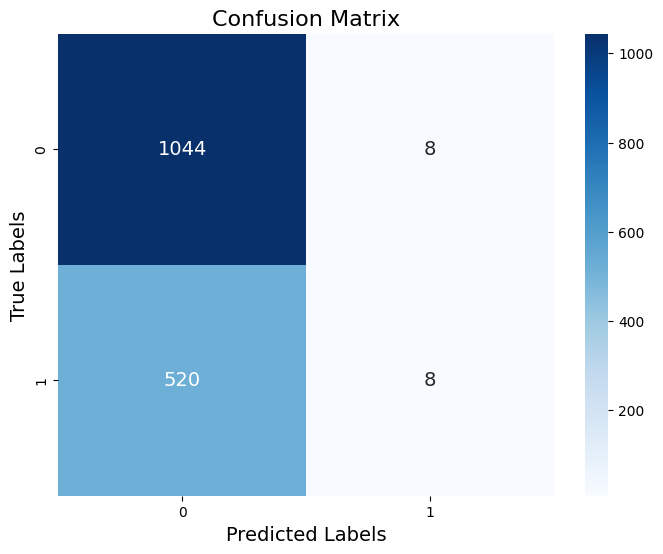

       participant                       filename  sound_prediction_score  \
0     CODA_TB_0002  1643791257235-recording-1.wav                0.990237   
1     CODA_TB_0002  1643791282515-recording-1.wav                0.984813   
2     CODA_TB_0002  1643791201453-recording-1.wav                0.989808   
3     CODA_TB_0002  1643791203573-recording-1.wav                0.990205   
4     CODA_TB_0002  1643791177587-recording-1.wav                0.990183   
...            ...                            ...                     ...   
1575  CODA_TB_1105  1645692755262-recording-1.wav                0.987976   
1576  CODA_TB_1105  1645692677308-recording-1.wav                0.989960   
1577  CODA_TB_1105  1645692700378-recording-1.wav                0.990154   
1578  CODA_TB_1105  1645692720921-recording-1.wav                0.990138   
1579  CODA_TB_1105  1645692738158-recording-1.wav                0.989462   

      label                                      relative_path split_label 

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Add a probability column to your DataFrame (assuming you have one)
df_test['probability'] = y_pred_probs

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("ROC AUC Score:", roc_auc)

# Calculate the optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Update y_pred_binary based on the optimal threshold
y_pred_binary_optimal = (y_pred_probs > optimal_threshold).astype(int)

# Print Sensitivity and Specificity
print("Sensitivity:", tpr[optimal_idx])
print("Specificity:", 1 - fpr[optimal_idx])

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary_optimal)

# Create a seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

print(df_test)
df_test.to_csv('solicited_individual_audio.csv', index=False)

#### Validating the performance of the model on individual patient

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

# Assuming df_val is your DataFrame with columns 'participant', 'label', and 'probability'
# Replace this with your actual DataFrame if necessary

# Function to calculate metrics at a given threshold
def calculate_metrics(y_true, y_prob, threshold=0.5):
    y_pred_binary = (y_prob > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_binary)
    
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
    
    return sensitivity, specificity, accuracy

# Function to print metrics for a given feature type (mean, median, range)
def print_metrics(feature_type, y_true, y_prob):
    print(f"\nMetrics for {feature_type.capitalize()} Probability:")

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_true, y_prob)
    print("ROC AUC Score:", roc_auc)

    # Calculate metrics for the default threshold (0.5)
    sensitivity_default, specificity_default, accuracy_default = calculate_metrics(y_true, y_prob)
    print("\nMetrics for Default Threshold (0.5):")
    print("Sensitivity:", sensitivity_default)
    print("Specificity:", specificity_default)
    print("Accuracy:", accuracy_default)

    # Iterate over different thresholds and find the optimal threshold
    thresholds = np.arange(0.0, 1.0, 0.0001)
    best_threshold = 0.5
    best_youden_index = 0

    for threshold in thresholds:
        sensitivity, specificity, _ = calculate_metrics(y_true, y_prob, threshold)

        youden_index = sensitivity + specificity - 1

        if youden_index > best_youden_index:
            best_youden_index = youden_index
            best_threshold = threshold

    print("\nBest Threshold (Optimal):", best_threshold)

    # Calculate metrics for the optimal threshold
    sensitivity_optimal, specificity_optimal, accuracy_optimal = calculate_metrics(y_true, y_prob, best_threshold)
    print("Metrics for Optimal Threshold:")
    print("Sensitivity:", sensitivity_optimal)
    print("Specificity:", specificity_optimal)
    print("Accuracy:", accuracy_optimal)

# Calculate and print metrics for mean probability
df_mean = df_test.groupby('participant', as_index=False).agg({'label': 'mean', 'probability': 'mean'})
print_metrics("mean", df_mean['label'], df_mean['probability'])

# Calculate and print metrics for median probability
df_median = df_test.groupby('participant', as_index=False).agg({'label': 'mean', 'probability': 'median'})
print_metrics("median", df_median['label'], df_median['probability'])

# Calculate and print metrics for range probability
df_range = df_test.groupby('participant', as_index=False).agg({'label': 'mean', 'probability': lambda x: np.max(x) - np.min(x)})
print_metrics("range", df_range['label'], df_range['probability'])

df_mean.to_csv('solicited_participant_mean.csv', index=False)
df_median.to_csv('solicited_participant_median.csv', index=False)
df_range.to_csv('solicited_participant_range.csv', index=False)



Metrics for Mean Probability:
ROC AUC Score: 0.5533536585365854

Metrics for Default Threshold (0.5):
Sensitivity: 0.0
Specificity: 1.0
Accuracy: 0.7192982456140351

Best Threshold (Optimal): 0.0
Metrics for Optimal Threshold:
Sensitivity: 0.25
Specificity: 0.8617886178861789
Accuracy: 0.6900584795321637

Metrics for Median Probability:
ROC AUC Score: 0.4959349593495935

Metrics for Default Threshold (0.5):
Sensitivity: 0.0
Specificity: 1.0
Accuracy: 0.7192982456140351

Best Threshold (Optimal): 0.5
Metrics for Optimal Threshold:
Sensitivity: 0.0
Specificity: 1.0
Accuracy: 0.7192982456140351

Metrics for Range Probability:
ROC AUC Score: 0.5525067750677506

Metrics for Default Threshold (0.5):
Sensitivity: 0.0
Specificity: 1.0
Accuracy: 0.7192982456140351

Best Threshold (Optimal): 0.0
Metrics for Optimal Threshold:
Sensitivity: 0.25
Specificity: 0.8617886178861789
Accuracy: 0.6900584795321637


In [35]:
print(df_mean.head(20))

     participant  label  probability
0   CODA_TB_0002    1.0          0.0
1   CODA_TB_0008    0.0          0.0
2   CODA_TB_0012    1.0          0.0
3   CODA_TB_0035    1.0          0.0
4   CODA_TB_0036    0.0          0.0
5   CODA_TB_0045    0.0          0.0
6   CODA_TB_0052    0.0          0.0
7   CODA_TB_0054    0.0          0.0
8   CODA_TB_0055    0.0          0.0
9   CODA_TB_0057    0.0          0.0
10  CODA_TB_0071    1.0          0.0
11  CODA_TB_0082    0.0          0.0
12  CODA_TB_0091    1.0          0.0
13  CODA_TB_0108    0.0          0.0
14  CODA_TB_0116    1.0          0.0
15  CODA_TB_0119    0.0          0.0
16  CODA_TB_0122    0.0          0.0
17  CODA_TB_0125    0.0          0.0
18  CODA_TB_0131    0.0          0.0
19  CODA_TB_0138    0.0          0.0
